Epoch 1/50


/tmp/ipykernel_13974/4015111970.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters = df.groupby([pd.Grouper(freq='M', key='incident_begin_date'), 'incident_type']).size()
/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0616 - val_loss: 0.0236
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0262 - val_loss: 0.0215
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0226 - val_loss: 0.0197
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0242 - val_loss: 0.0182
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0188 - val_loss: 0.0170
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0161 - val_loss: 0.0157
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0157 - val_loss: 0.0147
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0225 - val_loss: 0.0138
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0111 - val_loss: 0.0130
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0115 - val_loss: 0.0124
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0106 - val_loss: 0.0113


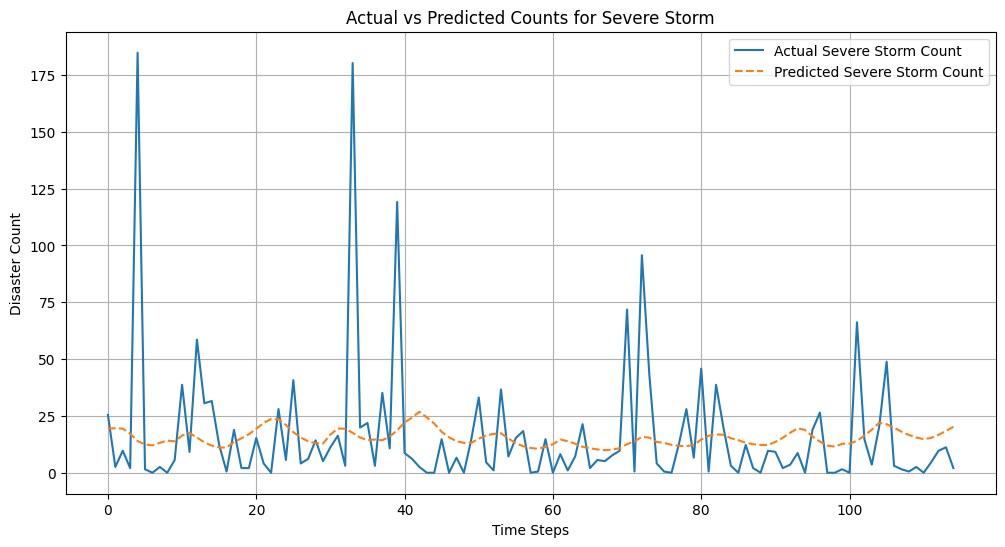

In [11]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Step 2: Load and Clean Data
df = pd.read_csv('../data/us_disaster_declarations.csv')

# Filter for mainland states
mainland_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df = df[df['state'].isin(mainland_states)]

# Drop irrelevant columns
columns_to_drop = [
    "fema_declaration_string", "fips", "place_code", "hash", "id", "last_refresh", 
    "last_ia_filing_date", "fy_declared", "ih_program_declared", "ia_program_declared", 
    "declaration_type", "pa_program_declared", "hm_program_declared", 
    "disaster_closeout_date", "declaration_request_number"
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Convert dates and sort
df['incident_begin_date'] = pd.to_datetime(df['incident_begin_date']).dt.tz_localize(None)
df.sort_values('incident_begin_date', inplace=True)

# Step 3: Filter Data and Separate Top 3 Features
top_3_disaster_types = df['incident_type'].value_counts().head(3).index
df = df[df['incident_type'].isin(top_3_disaster_types)]

# Aggregate monthly disaster counts
monthly_disasters = df.groupby([pd.Grouper(freq='M', key='incident_begin_date'), 'incident_type']).size()
monthly_disasters = monthly_disasters.unstack(fill_value=0)

# Add cyclical features for seasonality
monthly_disasters['month_sin'] = np.sin(2 * np.pi * (monthly_disasters.index.month / 12))
monthly_disasters['month_cos'] = np.cos(2 * np.pi * (monthly_disasters.index.month / 12))

# Step 4: Add Lagged Features and Rolling Averages
for col in top_3_disaster_types:
    for lag in range(1, 4):  # Add up to 3 lagged features
        monthly_disasters[f'{col}_lag_{lag}'] = monthly_disasters[col].shift(lag)
    # Add rolling mean for smoothing
    monthly_disasters[f'{col}_rolling_mean'] = monthly_disasters[col].rolling(window=3).mean()

# Drop rows with NaN values created by lagging and rolling
monthly_disasters.dropna(inplace=True)

# Step 5: Normalize Data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(monthly_disasters)
scaled_df = pd.DataFrame(scaled_features, columns=monthly_disasters.columns, index=monthly_disasters.index)

# Step 6: Create Sequences with Overlap
def create_sequences_with_overlap(data, seq_length, step_size=1):
    sequences = []
    labels = []
    for i in range(0, len(data) - seq_length, step_size):
        seq = data.iloc[i:i + seq_length].values
        label = data.iloc[i + seq_length][top_3_disaster_types[0]]  # Predict one disaster type as an example
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 24
X, y = create_sequences_with_overlap(scaled_df, seq_length, step_size=1)

# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Step 8: Build the Simplified LSTM Model with Regularization
model = Sequential([
    LSTM(32, activation='relu', return_sequences=False, input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.4),
    Dense(1, kernel_regularizer=l2(0.01))  # Add L2 regularization
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Step 9: Evaluate the Model
y_pred = model.predict(X_test)

# Rescale predictions and actual values back to the original scale
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred, X_test[:, -1, 1:])))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), X_test[:, -1, 1:])))[:, 0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot actual vs predicted values for the top disaster type
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label=f'Actual {top_3_disaster_types[0]} Count')
plt.plot(y_pred_rescaled, label=f'Predicted {top_3_disaster_types[0]} Count', linestyle='--')
plt.title(f'Actual vs Predicted Counts for {top_3_disaster_types[0]}')
plt.xlabel('Time Steps')
plt.ylabel('Disaster Count')
plt.legend()
plt.grid()
plt.show()
